# Advanced example: Higher-order statistics on the MICEv2 Catalog

**!!Warning!!** This notebook requires siginficant memory (~60GB) and CPU (~170h) resources!

In [1]:
import numpy as np
from astropy.table import Table

import orpheus

from matplotlib import pyplot as plt

## Create a mock catalog

### Query and download data

To create the dataset head over to [cosmohub](https://cosmohub.pic.es/catalogs/1) and enter the following query selecting galaxies that are in regions which are ´DES-complete´.

SELECT ra_gal, dec_gal, kappa, gamma1, gamma2, z_cgal, z_desdm_mc, sdss_r_true, des_asahi_full_i_true<br>
FROM cosmohub.micecatv2_0_view<br>
WHERE des_asahi_full_i_true - 0.8 * (ATAN(1.5 * z_cgal) - 0.1489) < 24<br>
AND (dec_gal>30.0<br>
     OR (dec_gal<30.0 AND ra_gal>30.0 AND ra_gal<60.0))<br>

Next, download the catalog somewhere.

In [2]:
path_to_cat = '/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/MICEv2/micev2_descomplete_orpheustutorial.fits'

### Create a tompgraphic setup

In this example we choose four equally populated bins. We further thin the catalog by a factor of ten.

In [3]:
micecat = Table.read(path_to_cat)

In [4]:
micecat.keys()

['ra_gal',
 'dec_gal',
 'kappa',
 'gamma1',
 'gamma2',
 'z_cgal',
 'z_desdm_mc',
 'sdss_r_true',
 'des_asahi_full_i_true']

In [5]:
fthin = 10

sel_ra = micecat['ra_gal']>0.
nbinsz = 4
zsort = np.argsort(micecat['z_desdm_mc'][sel_ra][::fthin])
ngal_tot = len(zsort)


0


1
2
3


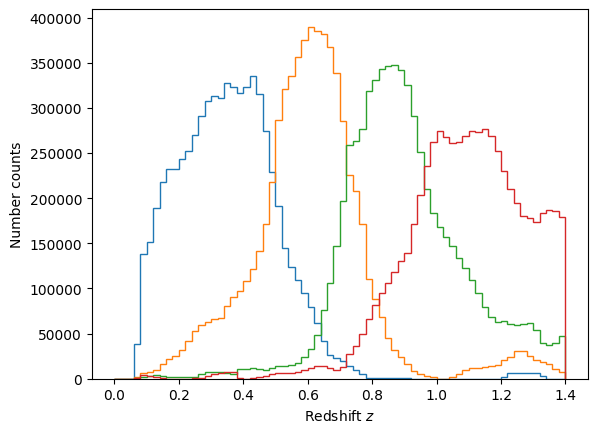

In [6]:
zbounds = np.zeros((nbinsz+1))
zsel = [None]*nbinsz
prevbound = 0
ras = np.zeros(ngal_tot)
decs = np.zeros(ngal_tot)
e1s = np.zeros(ngal_tot)
e2s = np.zeros(ngal_tot)
zinds = np.zeros(ngal_tot, dtype=np.int32)
for elz in range(nbinsz):
    print(elz)
    nextbound = int((elz+1)*0.25*ngal_tot)
    zbounds[elz+1] = zsort[nextbound-1]
    zsel[elz] = zsort[prevbound:nextbound]
    ras[prevbound:nextbound] = micecat['ra_gal'][sel_ra][::fthin][zsel[elz]]
    decs[prevbound:nextbound] = micecat['dec_gal'][sel_ra][::fthin][zsel[elz]]
    e1s[prevbound:nextbound] = micecat['gamma1'][sel_ra][::fthin][zsel[elz]]
    e2s[prevbound:nextbound] = micecat['gamma2'][sel_ra][::fthin][zsel[elz]]
    zinds[prevbound:nextbound] = elz
    prevbound = nextbound
    plt.hist(micecat['z_cgal'][sel_ra][::fthin][zsel[elz]],bins=np.linspace(0,1.4,71),histtype='step',label='zbin %i'%elz)
plt.xlabel('Redshift $z$')
plt.ylabel("Number counts")
plt.show()

## Allocate relevant `orpheus` instances

Keep in mind that when decomposing the catalogs into patches to use the `other_cats` parameter which enforces matching patches between the lens- and the source catalog.

In [24]:
sel_lenses = zinds < 2 # Only select lenses from lowest two zbins
sel_sources = zinds > 0 # Only select sources from largest three zbins
thin_lens = 5 # Additionally thin the lens catalog

In [25]:
sourcecat = orpheus.SpinTracerCatalog(
    spin=2, pos1=ras[sel_sources], pos2=decs[sel_sources], tracer_1=-e1s[sel_sources], tracer_2=-e2s[sel_sources], zbins=zinds[sel_sources],
    geometry='spherical', units_pos1='deg', units_pos2='deg')

lenscat = orpheus.ScalarTracerCatalog(
    pos1=ras[sel_lenses][::thin_lens], pos2=decs[sel_lenses][::thin_lens], tracer=np.ones_like(ras[sel_lenses][::thin_lens]), zbins=zinds[sel_lenses][::thin_lens],
    geometry='spherical', units_pos1='deg', units_pos2='deg')

print(sourcecat.ngal, lenscat.ngal)

19865593 2648746


In [26]:
npatches = 100
sourcecat.topatches(npatches=npatches, patchextend_deg=3., other_cats=[lenscat], verbose=True)

Computing inner region of patches
Took 55.393 seconds
Mapping catalog to healpix grid
Took 1.563 seconds
Building index hash
Took 2.096 seconds
Building buffer around patches
100/100Took 47.198 seconds


## Compute GNN statistics

In [27]:
min_sep = 0.25
max_sep = 180.
binsize=0.1
nmax=15
rmin_pixsize=15
tree_resos = [0,1.,2.,4.]
nthreads=48

In [28]:
gnn = orpheus.GNNCorrelation(min_sep=min_sep, max_sep=max_sep, binsize=binsize, nmaxs=nmax, tree_resos=tree_resos, rmin_pixsize=rmin_pixsize, 
                             verbosity=2, nthreads=nthreads)

### Process the data

Processing the data works the same way as for the flat-sky case by using the `.process` method. 

* In the GNN case we can individually select whether we want to use the tomographic information in the lens- and/or source catalog. 
* We need to set the `rotsignflip` parameter that relates to the convention on how the poles on the full-sky are defined. For simulated data I have always used `rotsignflip=False`. A simple test to choose the sign for `rotsignflip` would be to compute the shear2PCF and to make sure that xi- does not depend on the declination.
* Similar to the other statistics we can return the results from the individual patches using the `keep_patchres` parameter. 

In [29]:
# Warning, this takes ~20 CPUh!
gnn_patches = gnn.process(cat_source=sourcecat, cat_lens=lenscat, dotomo_lens=True, dotomo_source=True, rotsignflip=False, keep_patchres=True)

Doing patch 1/100
Done 99.82 per centDoing patch 2/100
Done 99.86 per centDoing patch 3/100
Done 99.86 per centDoing patch 4/100
Done 99.86 per centDoing patch 5/100
Done 99.82 per centDoing patch 6/100
Done 99.82 per centDoing patch 7/100
Done 99.86 per centDoing patch 8/100
Done 99.86 per centDoing patch 9/100
Done 99.81 per centDoing patch 10/100
Done 99.86 per centDoing patch 11/100
Done 99.86 per centDoing patch 12/100
Done 99.86 per centDoing patch 13/100
Done 99.75 per centDoing patch 14/100
Done 99.77 per centDoing patch 15/100
Done 99.82 per centDoing patch 16/100
Done 99.86 per centDoing patch 17/100
Done 99.82 per centDoing patch 18/100
Done 99.86 per centDoing patch 19/100
Done 99.86 per centDoing patch 20/100
Done 99.84 per centDoing patch 21/100
Done 99.87 per centDoing patch 22/100
Done 99.86 per centDoing patch 23/100
Done 99.86 per centDoing patch 24/100
Done 99.81 per centDoing patch 25/100
Done 99.86 per centDoing patch 26/100
Done 99.86 per centDoing patch 27/100
Do

In [30]:
centers_patches_gnn, npcf_multipoles_patches_gnn, npcf_multipoles_norm_patches_gnn = gnn_patches

Now let us collect the measurements, compute MNN on the individual patches, and plot the results. _(Note that in case you are solely interested in the MNN of the full footprint, the loop over the patches is not required)._

In [31]:
import sys
apradii = np.geomspace(1,32,21)

# Compute Map3 of full 3pcf
fskyMNN = gnn.computeNNM(radii=apradii)

# Compute Map3 of patchwise 3pcfs
allMNN = np.zeros((sourcecat.npatches, *fskyMNN.shape), dtype=fskyMNN.dtype)
for elp in range(sourcecat.npatches):
    sys.stdout.write('%i '%elp)
    _pinst = orpheus.GNNCorrelation(
                                    min_sep=gnn.min_sep, 
                                    max_sep=gnn.max_sep,
                                    nbinsr=gnn.nbinsr,
                                    nmaxs=gnn.nmaxs,
                                    nbinsphi=gnn.nbinsphi,
                                    nthreads=gnn.nthreads)
    _pinst.nbinsz_lens = gnn.nbinsz_lens
    _pinst.nbinsz_source = gnn.nbinsz_source
    _pinst.projection = 'X'
    _pinst.bin_centers_mean = np.mean(centers_patches_gnn[elp],axis=(0,1))
    _pinst.npcf_multipoles = npcf_multipoles_patches_gnn[elp]
    _pinst.npcf_multipoles_norm = npcf_multipoles_norm_patches_gnn[elp]
    _pmnn = _pinst.computeNNM(radii=apradii)
    allMNN[elp] += 1*_pmnn

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [32]:
# Choose as effective weights the sum over the n===0 multipole
MNN_effws = np.sum(npcf_multipoles_norm_patches_gnn[:,0], axis=(-1,-2)).real
MNN_effws /= np.mean(MNN_effws,axis=0)
MNN_stds_re = np.std(allMNN.real[:,0],axis=0)
MNN_stds_im = np.std(allMNN.imag[:,0],axis=0)
_V1 = np.sum(MNN_effws,axis=0)
_V2 = np.sum(MNN_effws**2,axis=0)
MMN_samplestd_re = np.sqrt(np.sum(MNN_effws.real[...,np.newaxis]*(allMNN.real[:,0]-fskyMNN.real)**2,axis=0)/(_V1-_V2/_V1**2)[:,np.newaxis])
MMN_samplestd_im = np.sqrt(np.sum(MNN_effws.real[...,np.newaxis]*(allMNN.imag[:,0]-fskyMNN.imag)**2,axis=0)/(_V1-_V2/_V1**2)[:,np.newaxis])

/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


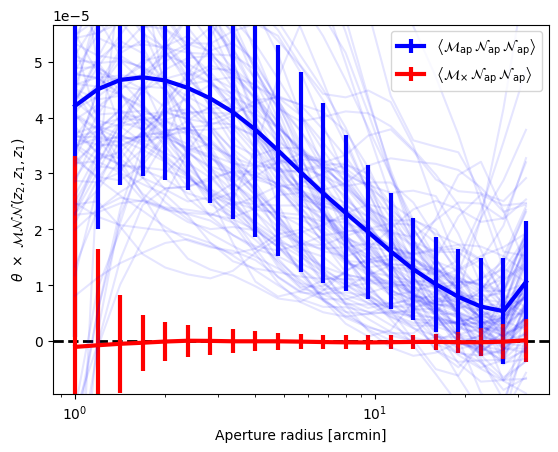

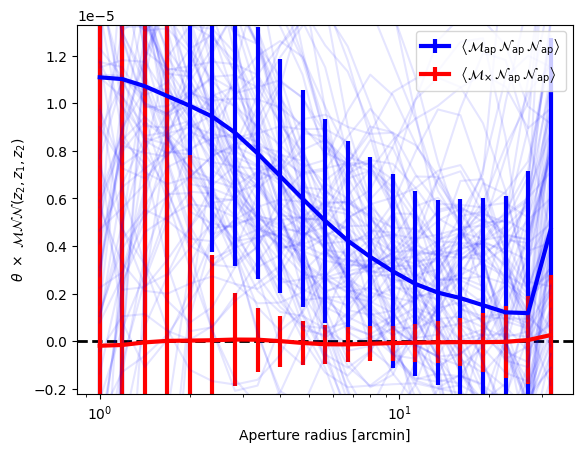

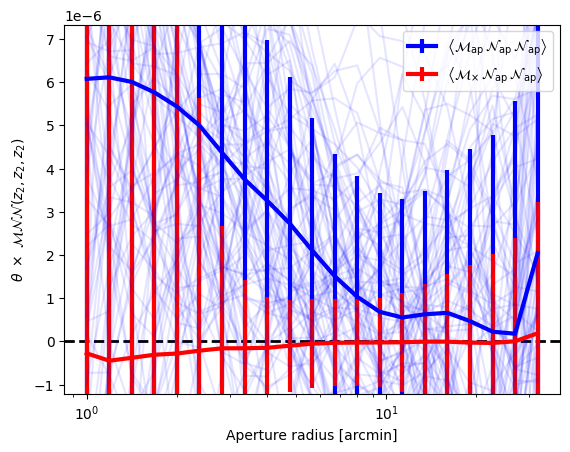

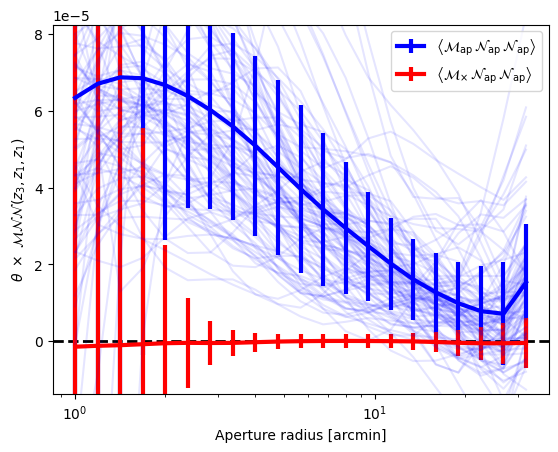

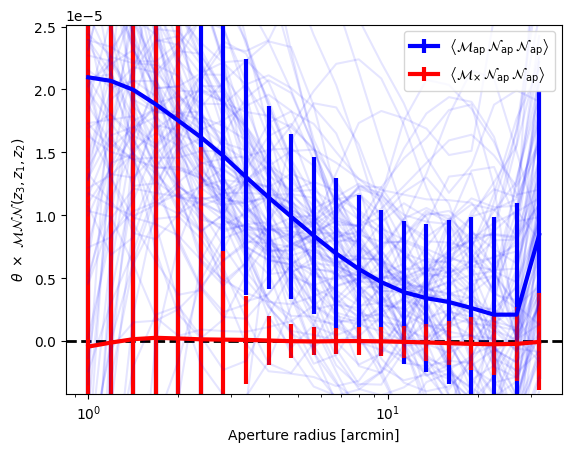

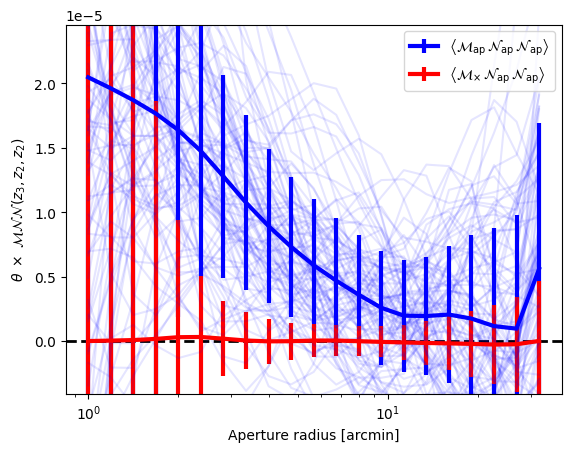

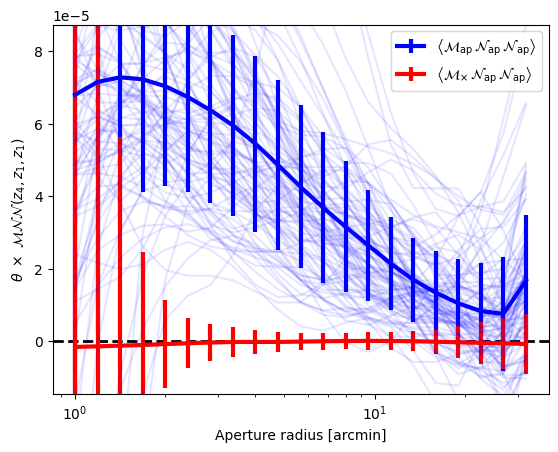

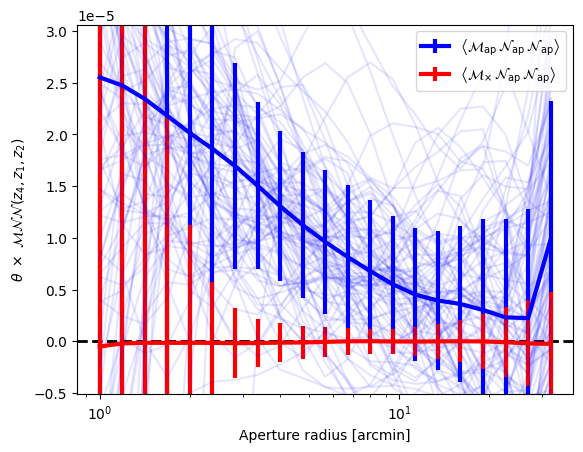

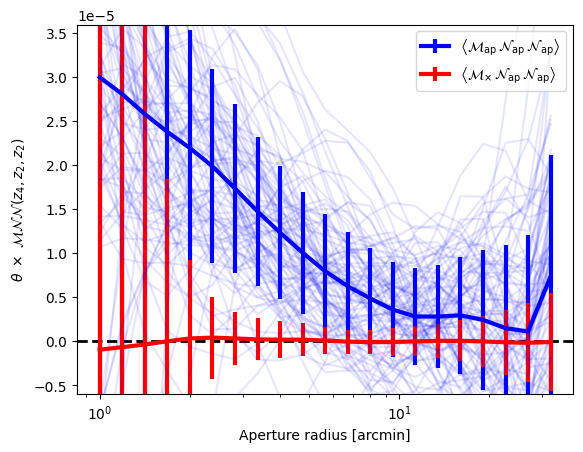

In [33]:
for sbin in range(sourcecat.nbinsz):
    for lbin1 in range(lenscat.nbinsz):
         for lbin2 in range(lbin1,lenscat.nbinsz):
            elzcombi = sbin*lenscat.nbinsz**2 + lbin1*lenscat.nbinsz + lbin2
            plt.axhline(0,color='black',ls='--',lw=2)
            plt.errorbar(x=apradii,
                         y=apradii*fskyMNN[0,elzcombi].real,
                         yerr=apradii*MMN_samplestd_re[elzcombi],color='blue',lw=3,
                         label=r'$\left\langle\mathcal{M}_{\rm ap} \, \mathcal{N}_{\rm ap} \, \mathcal{N}_{\rm ap}\right\rangle$'
                         )
            plt.errorbar(x=apradii,
                         y=apradii*fskyMNN[0,elzcombi].imag,
                         yerr=apradii*MMN_samplestd_im[elzcombi],color='red',lw=3,
                         label=r'$\left\langle\mathcal{M}_{\times} \, \mathcal{N}_{\rm ap} \, \mathcal{N}_{\rm ap}\right\rangle$')
            for elp in range(sourcecat.npatches):
                plt.semilogx(apradii, apradii*allMNN[elp,0,elzcombi],color='blue',alpha=0.1)
            plt.xlabel('Aperture radius [arcmin]')
            plt.ylabel(r'$\theta \ \times \ \mathcal{MNN}(z_%i,z_%i,z_%i)$'%(2+sbin,1+lbin1,1+lbin2))
            plt.ylim(-0.2*np.max(apradii*fskyMNN[0,elzcombi].real),1.2*np.max(apradii*fskyMNN[0,elzcombi].real))
            plt.legend(loc='upper right')
            plt.show()

## Compute NGG statistics

In [36]:
min_sep = 0.25
max_sep = 180.
binsize=0.1
nmax=15
rmin_pixsize=40 # We choose a large value here as a small one might produce an artificial B-Mode
tree_resos = [0.,1.,2.]
nthreads=48

In [37]:
ngg = orpheus.NGGCorrelation(min_sep=min_sep, max_sep=max_sep, binsize=binsize, nmaxs=nmax,
                             tree_resos=tree_resos, rmin_pixsize=rmin_pixsize, verbosity=2, nthreads=nthreads)

In [38]:
%%time
# Warning, this takes ~50 CPUh!
ngg_patches = ngg.process(cat_source=sourcecat, cat_lens=lenscat, dotomo_lens=True, dotomo_source=True, rotsignflip=False, keep_patchres=True)

Doing patch 1/100
..........................................................................................Doing patch 2/100
..........................................................................................Doing patch 3/100
..........................................................................................Doing patch 4/100
..........................................................................................Doing patch 5/100
..........................................................................................Doing patch 6/100
..........................................................................................Doing patch 7/100
..........................................................................................Doing patch 8/100
..........................................................................................Doing patch 9/100
..........................................................................................Doing patch 10/100
.........

In [42]:
centers_patches_ngg, npcf_multipoles_patches_ngg, npcf_multipoles_norm_patches_ngg = ngg_patches

In [43]:
import sys
apradii = np.geomspace(1,32,21)

# Compute Map3 of full 3pcf
fskyNMM = ngg.computeNMM(radii=apradii)

# Compute Map3 of patchwise 3pcfs
allNMM = np.zeros((sourcecat.npatches, *fskyNMM.shape), dtype=fskyNMM.dtype)
for elp in range(sourcecat.npatches):
    sys.stdout.write('%i '%elp)
    _pinst = orpheus.NGGCorrelation(
                                    min_sep=ngg.min_sep, 
                                    max_sep=ngg.max_sep,
                                    nbinsr=ngg.nbinsr,
                                    nmaxs=ngg.nmaxs,
                                    nbinsphi=ngg.nbinsphi,
                                    nthreads=ngg.nthreads)
    _pinst.nbinsz_lens = ngg.nbinsz_lens
    _pinst.nbinsz_source = ngg.nbinsz_source
    _pinst.projection = 'X'
    _pinst.bin_centers_mean = np.mean(centers_patches_ngg[elp],axis=(0,1))
    _pinst.npcf_multipoles = npcf_multipoles_patches_ngg[elp]
    _pinst.npcf_multipoles_norm = npcf_multipoles_norm_patches_ngg[elp]
    #if elp==0:
    #    filtercache = []
    #    for elr, r in enumerate(apradii):
    #        filtercache.append(_pinst._NMM_filtergrid(r, r, r))
    _pnmm = _pinst.computeNMM(radii=apradii)
    allNMM[elp] += 1*_pnmm

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [44]:
# Choose as effective weights the sum over the n===0 multipole
NMM_effws = np.sum(npcf_multipoles_norm_patches_ngg[:,0], axis=(-1,-2)).real
NMM_effws /= np.mean(NMM_effws,axis=0)
NMM_stds_re = np.std(allNMM.real[:,0],axis=0)
NMM_stds_im = np.std(allNMM.imag[:,0],axis=0)
_V1 = np.sum(NMM_effws,axis=0)
_V2 = np.sum(NMM_effws**2,axis=0)
NMM_samplestd_re = np.sqrt(np.sum(NMM_effws.real[:,np.newaxis,:,np.newaxis]*(allNMM.real-fskyNMM.real)**2,axis=0)/(_V1-_V2/_V1**2)[:,np.newaxis])
NMM_samplestd_im = np.sqrt(np.sum(NMM_effws.real[:,np.newaxis,:,np.newaxis]*(allNMM.imag-fskyNMM.imag)**2,axis=0)/(_V1-_V2/_V1**2)[:,np.newaxis])

/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


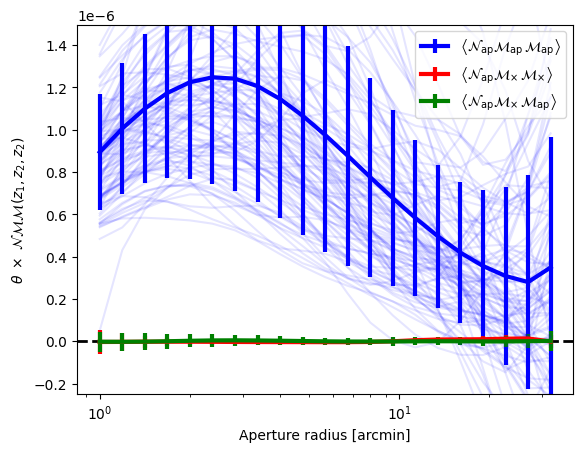

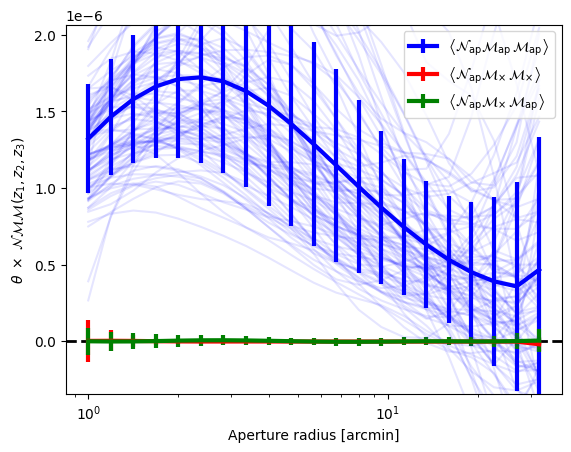

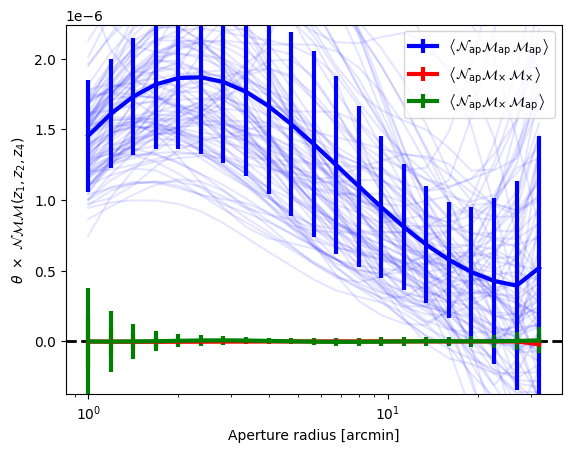

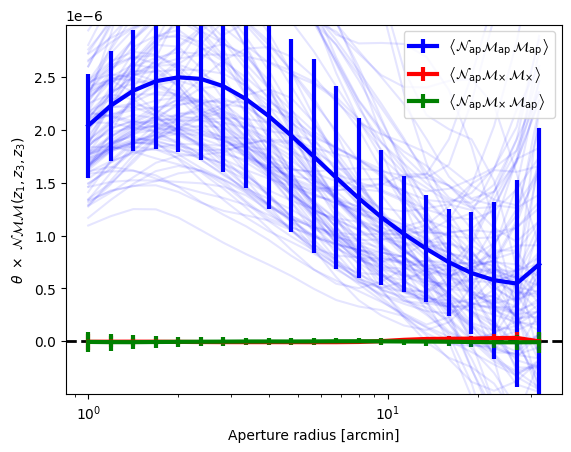

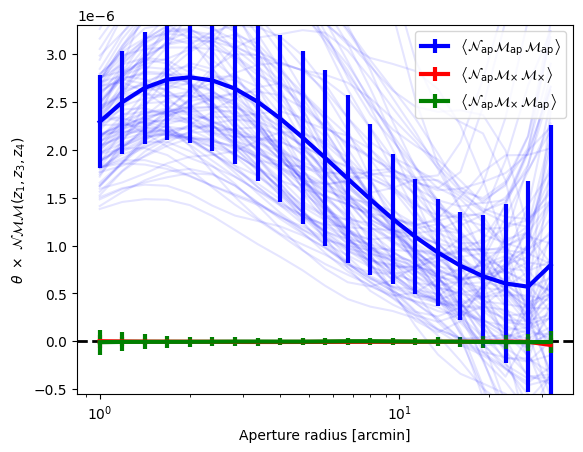

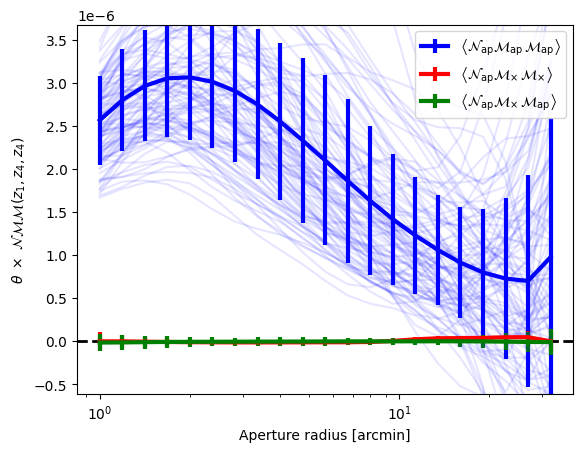

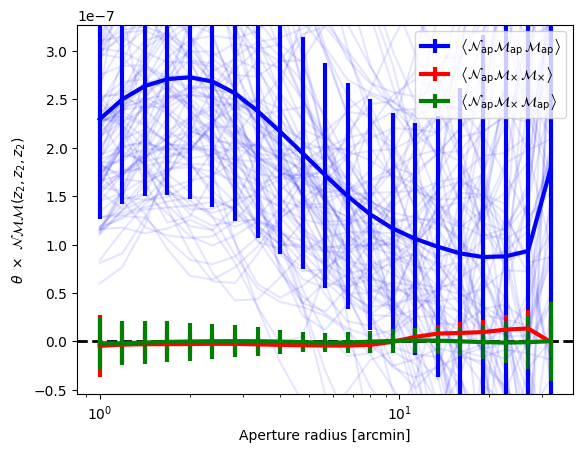

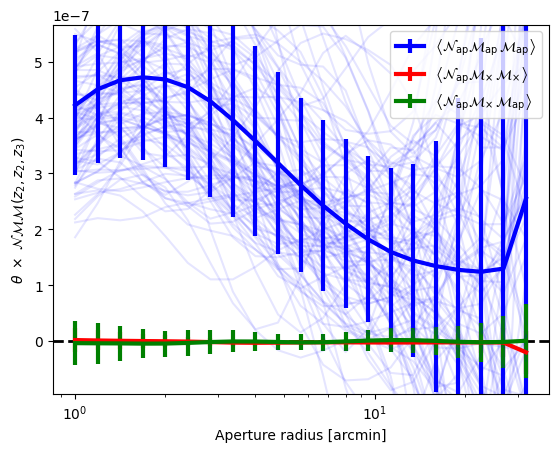

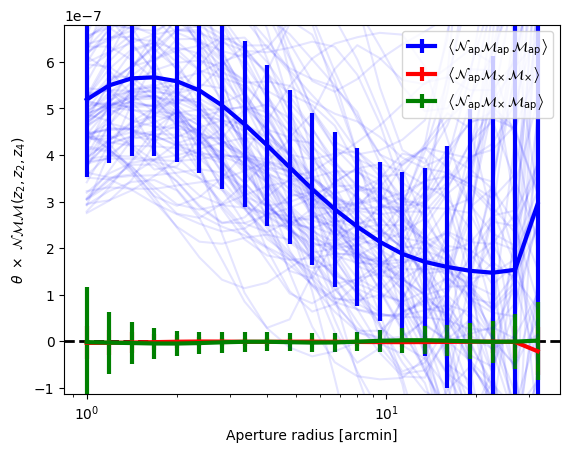

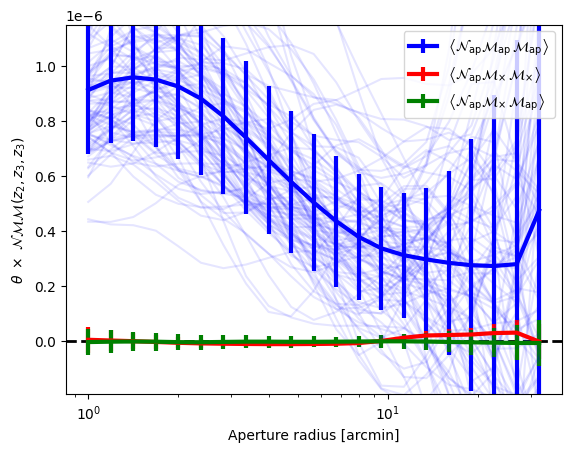

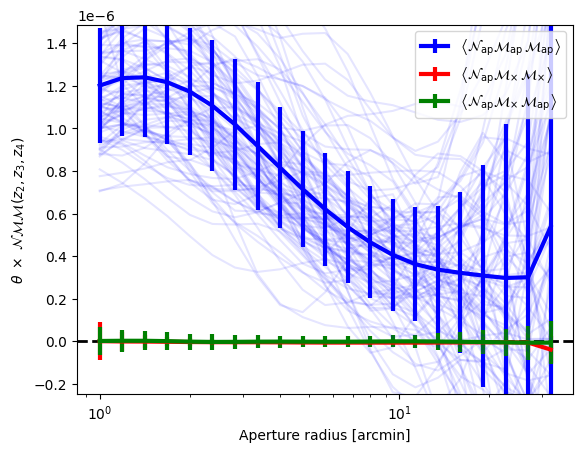

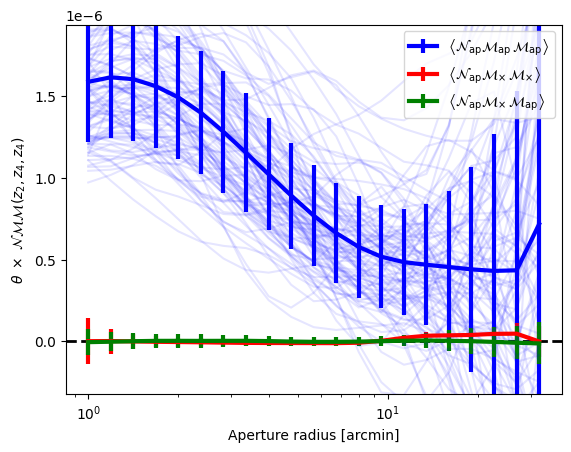

In [45]:
for lbin in range(lenscat.nbinsz):
    for sbin1 in range(sourcecat.nbinsz):
         for sbin2 in range(sbin1, sourcecat.nbinsz):
            elzcombi = lbin*sourcecat.nbinsz**2 + sbin1*sourcecat.nbinsz + sbin2
            plt.axhline(0,color='black',ls='--',lw=2)
            plt.errorbar(x=apradii,
                         y=apradii*fskyNMM[0,elzcombi].real,
                         yerr=apradii*NMM_samplestd_re[0,elzcombi],color='blue',lw=3,
                         label=r'$\left\langle\mathcal{N}_{\rm ap} \mathcal{M}_{\rm ap} \, \mathcal{M}_{\rm ap}\right\rangle$')
            plt.errorbar(x=apradii,
                         y=apradii*fskyNMM[1,elzcombi].real,
                         yerr=apradii*NMM_samplestd_re[1,elzcombi],color='red',lw=3,
                         label=r'$\left\langle\mathcal{N}_{\rm ap} \mathcal{M}_{\times} \, \mathcal{M}_{\times}\right\rangle$')
            plt.errorbar(x=apradii,
                         y=apradii*fskyNMM[2,elzcombi].real,
                         yerr=apradii*NMM_samplestd_re[2,elzcombi],color='green',lw=3,
                         label=r'$\left\langle\mathcal{N}_{\rm ap} \mathcal{M}_{\times} \, \mathcal{M}_{\rm ap}\right\rangle$')
            for elp in range(sourcecat.npatches):
                plt.semilogx(apradii, apradii*allNMM[elp,0,elzcombi],color='blue',alpha=0.1)
                
            plt.xlabel('Aperture radius [arcmin]')
            plt.ylabel(r'$\theta \ \times \ \mathcal{NMM}(z_%i,z_%i,z_%i)$'%(1+lbin,2+sbin1,2+sbin2))
            plt.ylim(-0.2*np.max(apradii*fskyNMM[0,elzcombi].real),1.2*np.max(apradii*fskyNMM[0,elzcombi].real))
            plt.legend(loc='upper right')
            plt.show()

## Compute GGG statistics

In [46]:
min_sep = 0.25
max_sep = 180.
binsize=0.1
nmax=15
rmin_pixsize=15
tree_resos = [0,1.,2.,4.]
nthreads=48

In [47]:
ggg = orpheus.GGGCorrelation(n_cfs=4,min_sep=min_sep, max_sep=max_sep, binsize=binsize, tree_resos=tree_resos, rmin_pixsize=rmin_pixsize, 
                             verbosity=2, nthreads=nthreads)

In [48]:
# Warning, this takes ~100 CPUh!
ggg_patches = ggg.process(cat=sourcecat, dotomo=True, rotsignflip=False, keep_patchres=True)

Doing patch 1/100


..........................................................................................
Doing patch 2/100
..........................................................................................
Doing patch 3/100
...........................................................................................
Doing patch 4/100
...........................................................................................
Doing patch 5/100
...........................................................................................
Doing patch 6/100
..........................................................................................
Doing patch 7/100
...........................................................................................
Doing patch 8/100
..........................................................................................
Doing patch 9/100
..........................................................................................
Doing patch 10/100
..............

In [49]:
centers_patches_ggg, npcf_multipoles_patches_ggg, npcf_multipoles_norm_patches_ggg = ggg_patches

In [50]:
apradii = np.geomspace(1,32,21)

filtercache_ggg = [None]*len(apradii)
for elapr, apr in enumerate(apradii):
    filtercache_ggg[elapr] = ggg._map3_filtergrid_singleR(apr,apr,apr)

# Compute Map3 of full 3pcf
fskyMMM = ggg.computeMap3(radii=apradii, filtercache=filtercache_ggg)

# Compute Map3 of patchwise 3pcfs
allMMM = np.zeros((sourcecat.npatches, *fskyMMM.shape), dtype=fskyMMM.dtype)
for elp in range(sourcecat.npatches):
    sys.stdout.write('%i '%elp)
    _pinst = orpheus.GGGCorrelation(n_cfs=4,
                                    min_sep=ggg.min_sep, 
                                    max_sep=ggg.max_sep,
                                    nbinsr=ggg.nbinsr,
                                    nmaxs=ggg.nmaxs,
                                    nbinsphi=ggg.nbinsphi,
                                    nthreads=ggg.nthreads)
    _pinst.nbinsz = ggg.nbinsz
    _pinst.nzcombis = ggg.nzcombis
    _pinst.projection = 'X'
    _pinst.bin_centers_mean = np.mean(centers_patches_ggg[elp],axis=(0))
    _pinst.npcf_multipoles = npcf_multipoles_patches_ggg[elp]
    _pinst.npcf_multipoles_norm = npcf_multipoles_norm_patches_ggg[elp]
    _pmmm = _pinst.computeMap3(radii=apradii, filtercache=filtercache_ggg)
    del _pinst
    allMMM[elp] += 1*_pmmm

0 1 2 

3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [51]:
# Choose as effective weights the sum over the n===0 multipole
MMM_effws = np.sum(npcf_multipoles_norm_patches_ggg[:,0], axis=(-1,-2)).real
MMM_effws /= np.mean(MMM_effws,axis=0)
MMM_stds_re = np.std(allMMM.real[:,0],axis=0)
MMM_stds_im = np.std(allMMM.imag[:,0],axis=0)
_V1 = np.sum(MMM_effws,axis=0)
_V2 = np.sum(MMM_effws**2,axis=0)
MMM_samplestd_re = np.sqrt(np.sum(MMM_effws.real[:,np.newaxis,:,np.newaxis]*(allMMM.real-fskyMMM.real)**2,axis=0)/(_V1-_V2/_V1**2)[:,np.newaxis])
MMM_samplestd_im = np.sqrt(np.sum(MMM_effws.real[:,np.newaxis,:,np.newaxis]*(allMMM.imag-fskyMMM.imag)**2,axis=0)/(_V1-_V2/_V1**2)[:,np.newaxis])

/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


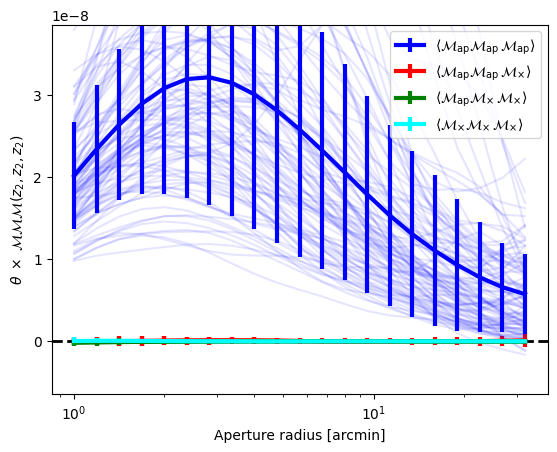

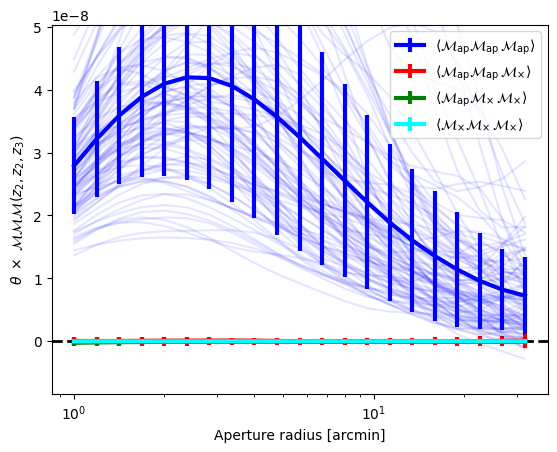

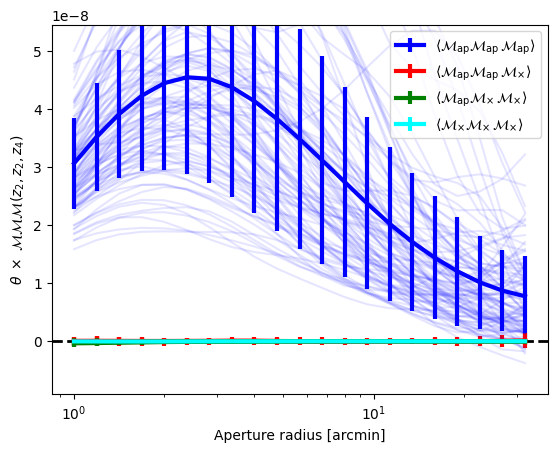

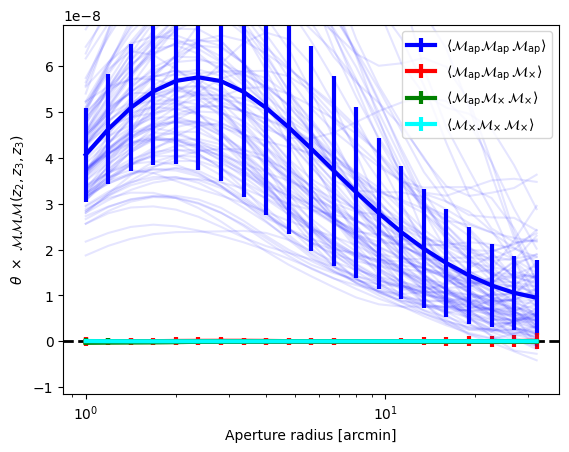

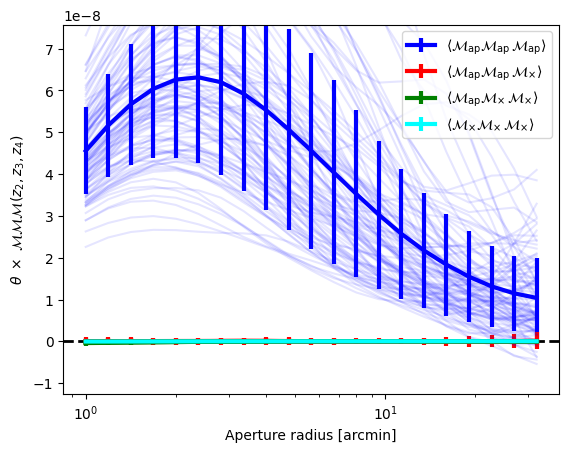

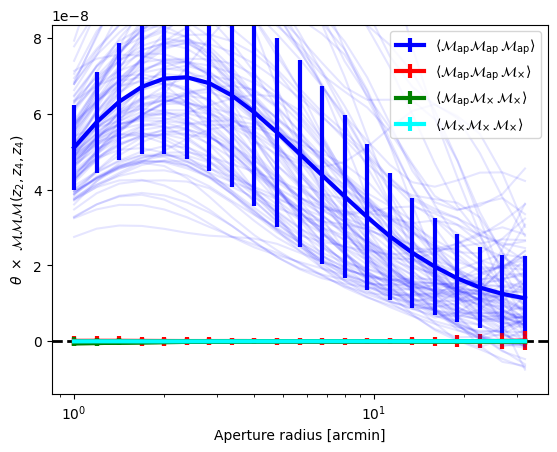

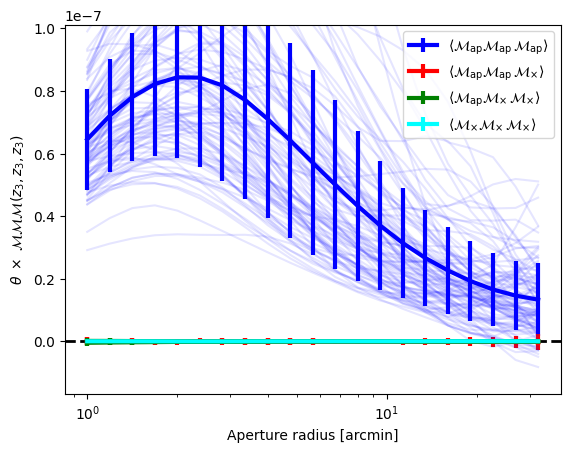

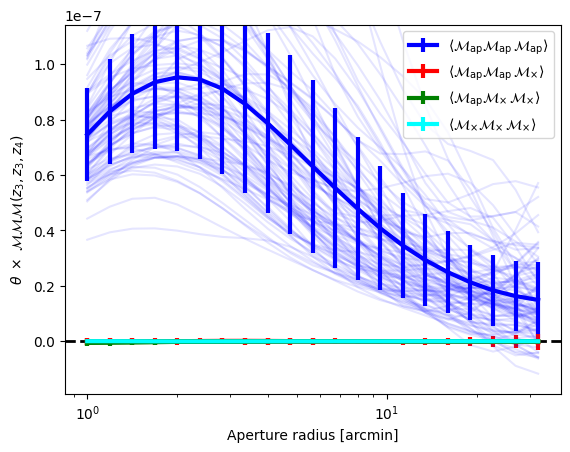

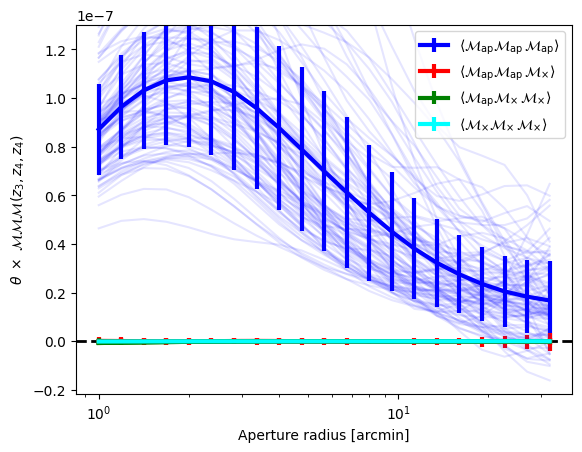

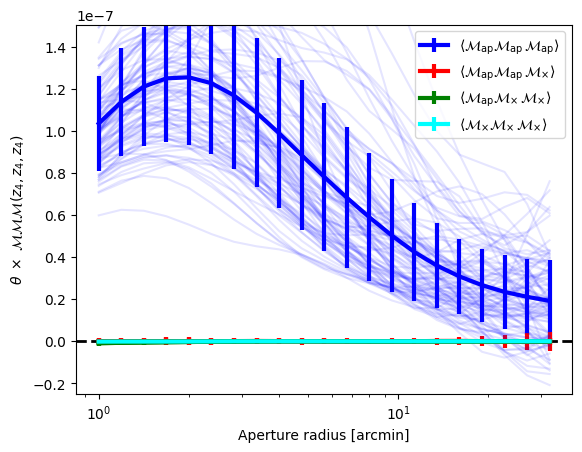

In [52]:
for sbin1 in range(sourcecat.nbinsz):
    for sbin2 in range(sbin1,sourcecat.nbinsz):
         for sbin3 in range(sbin2, sourcecat.nbinsz):
            elzcombi = sbin1*sourcecat.nbinsz**2 + sbin2*sourcecat.nbinsz + sbin3
            plt.axhline(0,color='black',ls='--',lw=2)
            plt.errorbar(x=apradii,
                         y=apradii*fskyMMM[0,elzcombi].real,
                         yerr=apradii*MMM_samplestd_re[0,elzcombi],color='blue',lw=3,
                         label=r'$\left\langle\mathcal{M}_{\rm ap} \mathcal{M}_{\rm ap} \, \mathcal{M}_{\rm ap}\right\rangle$')
            plt.errorbar(x=apradii,
                         y=apradii*fskyMMM[1,elzcombi].real,
                         yerr=apradii*MMM_samplestd_re[1,elzcombi],color='red',lw=3,
                         label=r'$\left\langle\mathcal{M}_{\rm ap} \mathcal{M}_{\rm ap} \, \mathcal{M}_{\times}\right\rangle$')
            plt.errorbar(x=apradii,
                         y=apradii*fskyMMM[2,elzcombi].real,
                         yerr=apradii*MMM_samplestd_re[2,elzcombi],color='red',lw=3)
            plt.errorbar(x=apradii,
                         y=apradii*fskyMMM[3,elzcombi].real,
                         yerr=apradii*MMM_samplestd_re[3,elzcombi],color='red',lw=3)
            plt.errorbar(x=apradii,
                         y=apradii*fskyMMM[4,elzcombi].real,
                         yerr=apradii*MMM_samplestd_re[4,elzcombi],color='green',lw=3,
                         label=r'$\left\langle\mathcal{M}_{\rm ap} \mathcal{M}_{\times} \, \mathcal{M}_{\times}\right\rangle$')
            plt.errorbar(x=apradii,
                         y=apradii*fskyMMM[5,elzcombi].real,
                         yerr=apradii*MMM_samplestd_re[5,elzcombi],color='green',lw=3)
            plt.errorbar(x=apradii,
                         y=apradii*fskyMMM[6,elzcombi].real,
                         yerr=apradii*MMM_samplestd_re[6,elzcombi],color='green',lw=3)
            plt.errorbar(x=apradii,
                         y=apradii*fskyMMM[7,elzcombi].real,
                         yerr=apradii*MMM_samplestd_re[7,elzcombi],color='cyan',lw=3,
                         label=r'$\left\langle\mathcal{M}_{\times} \mathcal{M}_{\times} \, \mathcal{M}_{\times}\right\rangle$')
            for elp in range(sourcecat.npatches):
                plt.semilogx(apradii, apradii*allMMM[elp,0,elzcombi],color='blue',alpha=0.1)
                
            plt.xlabel('Aperture radius [arcmin]')
            plt.ylabel(r'$\theta \ \times \ \mathcal{MMM}(z_%i,z_%i,z_%i)$'%(2+sbin1,2+sbin2,2+sbin3))
            plt.ylim(-0.2*np.max(apradii*fskyMMM[0,elzcombi].real),1.2*np.max(apradii*fskyMMM[0,elzcombi].real))
            plt.legend(loc='upper right')
            plt.show()